In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
print(os.listdir("../input/"))

['test', 'train', 'train.csv', 'sample_submission.csv']


## Read and set up data

In [3]:
# Read data
train_dir = "../input/train/train/"
test_dir = "../input/test/test/"

train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


Image shape = (32, 32, 3)


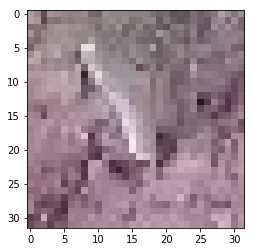

In [4]:
# Read and display an image
image = plt.imread(os.path.join(train_dir, os.listdir(train_dir)[0]))
print("Image shape =", image.shape)
train_input_shape = image.shape
plt.imshow(image)
plt.show()

## Image Augmentation

In [5]:
# Augment data
batch_size = 16
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="id", 
                                                    y_col="has_cactus", 
                                                    class_mode="other",
                                                    subset="training",
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=batch_size)

valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="id", 
                                                    y_col="has_cactus", 
                                                    class_mode="other",
                                                    subset="validation",
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=batch_size)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 14000 images.
Found 3500 images.
Total number of batches = 875 and 218


## Build model

In [6]:
# Load pre-trained model
vgg19_net = VGG19(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in vgg19_net.layers:
    layer.trainable = True

#vgg19_net.summary()

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [7]:
# Add layers at the end
X = vgg19_net.output
X = Flatten()(X)

X = Dropout(0.5)(X)
X = Dense(256, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dropout(0.5)(X)
X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dropout(0.5)(X)
X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(1, activation='sigmoid')(X)

model = Model(inputs=vgg19_net.input, outputs=output)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

In [9]:
n_epoch = 100

early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

In [10]:
%%time
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[early_stop, reduce_lr],
                              use_multiprocessing=True,
                              workers=10
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
875/875 [==============================] - 42s 48ms/step - loss: 0.3487 - acc: 0.8935 - val_loss: 0.6441 - val_acc: 0.5114
Epoch 2/100
875/875 [==============================] - 36s 42ms/step - loss: 0.1890 - acc: 0.9602 - val_loss: 0.1620 - val_acc: 0.9754
Epoch 3/100
875/875 [==============================] - 38s 43ms/step - loss: 0.1457 - acc: 0.9616 - val_loss: 0.0870 - val_acc: 0.9769
Epoch 4/100
875/875 [==============================] - 36s 41ms/step - loss: 0.1121 - acc: 0.9686 - val_loss: 0.0539 - val_acc: 0.9846
Epoch 5/100
875/875 [==============================] - 37s 43ms/step - loss: 0.0916 - acc: 0.9761 - val_loss: 0.0590 - val_acc: 0.9826
Epoch 6/100
875/875 [==============================] - 37s 42ms/step - loss: 0.0767 - acc: 0.9797 - val_loss: 0.1029 - val_acc: 0.9806
Epoch 7/100
875/875 [==============================] - 39s 44ms/step - loss: 0.0771 - acc: 0.9791 - val_loss: 0.0463 - val_acc: 0.9851
Epoch 8

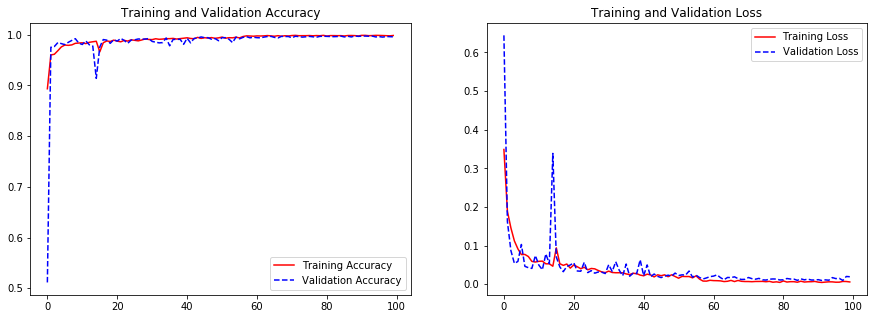

In [11]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [12]:
# Evaluate on validation set
result = model.evaluate_generator(generator=valid_generator, verbose=1)
result

219/219 [==============================] - 5s 23ms/step - loss: 0.0129 - acc: 0.9960


[0.01292806052487276, 0.996]

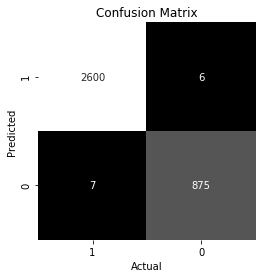

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       881
           1       1.00      1.00      1.00      2607

   micro avg       1.00      1.00      1.00      3488
   macro avg       0.99      1.00      1.00      3488
weighted avg       1.00      1.00      1.00      3488


AUC:  0.9952522393433901


In [13]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Prediction vector based on threshold
    y_pred = np.asarray(y_pred).astype('float32').ravel()
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype('int').ravel()
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels = [1,0])
    sns.heatmap(conf_matrix.T, annot=True, fmt="d", square=True, cbar=False, 
                cmap=plt.cm.gray, xticklabels=[1,0], yticklabels=[1,0])
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=['0','1']))
    print("\nAUC: ", roc_auc_score(y_true, y_pred))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

## Prepare data for prediction on test set

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = '../input/test'
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  class_mode=None,
                                                  target_size=train_input_shape[0:2],
                                                  batch_size=1,
                                                  shuffle=False
                                                 )

Found 4000 images belonging to 1 classes.


## Predict and Submit

In [15]:
# Predict on test data
test_generator.reset()
predictions = model.predict_generator(test_generator,verbose=1)
predictions = predictions >= 0.5
predictions = predictions.astype('int').ravel()
predictions.shape

4000/4000 [==============================] - 34s 8ms/step


(4000,)

In [16]:
# Retrieve filenames
import re
test_img_ids = [re.split("/", val)[1] for val in test_generator.filenames]
len(test_img_ids)

4000

In [17]:
# Create dataframe for submission
submission_df = pd.DataFrame({'id' : test_img_ids,
                              'has_cactus' : predictions })
submission_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1


In [18]:
# Create submission file
submission_df.to_csv('submission.csv', index=False)